In [8]:
#
# Run the hbv parameter estimation with full model
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/hbv_det.m
#

In [24]:
from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd
from scipy.stats import t
from scipy.linalg import eig
import scipy.linalg as sla

In [10]:
filename = 'hbv_data.csv'
D_frame = read_file(filename, directory = 'data_sets')

read dir : /home/paperspace/learn_kipet/kipet_paresto/data_sets/hbv_data.csv


In [11]:
D_frame.shape

(50, 3)

In [12]:
D_frame.head()

,A,B,C
0.000000,1.051482,-0.000739,-0.000501
2.040816,0.718060,2.599459,371.265832
4.081633,0.641247,5.702485,325.080882
6.122449,0.657471,6.944847,296.171685
8.163265,0.772015,9.147780,291.254375


In [13]:
builder = TemplateBuilder()    
components = {'A':1,'B':0,'C':0}
builder.add_mixture_component(components)

# in the book they fit log10(k). Here I tried directly fitting k. Seems to work in this case
builder.add_parameter('k1',initialize = 100, bounds=(0.0,5e3))
builder.add_parameter('k2',initialize = 100, bounds=(0.0,5e3))
builder.add_parameter('k3',initialize = 100, bounds=(0.0,5e3))
builder.add_parameter('k4',initialize = 100, bounds=(0.0,5e3))
builder.add_parameter('k5',initialize = 100, bounds=(0.0,5e3))
builder.add_parameter('k6',initialize = 100, bounds=(0.0,5e3))

builder.add_concentration_data(D_frame)

Warning! Since C-matrix contains negative values Kipet is assuming a derivative of C has been inputted


In [14]:
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = m.P['k2']*m.Z[t,'B'] - m.P['k4']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']-m.P['k6']*m.Z[t,'B']*m.Z[t,'C']
    exprs['C'] = m.P['k3']*m.Z[t,'A']-m.P['k5']*m.Z[t,'C']-m.P['k6']*m.Z[t,'B']*m.Z[t,'C']
    return exprs

builder.set_odes_rule(rule_odes)
opt_model = builder.create_pyomo_model(0.0,100.0)

In [15]:
# sigmas as 1/wts used in the book
sigmas = {'A':1, 'B':100, 'C':1e4}
p_estimator = ParameterEstimator(opt_model)
p_estimator.apply_discretization('dae.collocation',nfe=50,ncp=3,scheme='LAGRANGE-RADAU')

In [16]:
options = dict()
results_pyomo = p_estimator.run_opt('k_aug',
                                    variances=sigmas,
                                  tee=True,
                                  solver_opts = options,
                                  covariance=True)

        0.11 seconds required to write file
        0.11 seconds required for presolve
Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     5103
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1350

Total number of variables............................:      909
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        6
                     variables with only upper bounds:        0
T

 101  1.2867071e+06 4.04e+01 1.90e+07  -1.7 1.25e+02   0.9 1.00e+00 9.96e-05h  1
 102  1.2870772e+06 2.60e+01 2.05e+07  -1.7 8.73e+01   0.4 1.00e+00 5.00e-01h  2
 103  1.2874216e+06 1.95e+01 1.27e+07  -1.7 9.57e+01  -0.1 2.56e-01 2.50e-01h  3
 104  1.2878080e+06 1.50e+01 2.82e+07  -1.7 1.11e+02  -0.6 1.75e-03 2.50e-01h  3
 105  1.2877314e+06 1.89e+01 2.65e+07  -1.7 2.71e+03  -1.0 6.22e-05 1.61e-02f  4
 106  1.2876895e+06 3.47e+01 3.28e+07  -1.7 1.61e+02  -0.6 1.16e-01 5.00e-01f  2
 107  1.2875061e+06 3.94e+00 7.21e+05  -1.7 4.15e+01   0.7 9.41e-01 1.00e+00f  1
 108  1.2875989e+06 2.63e-01 2.71e+05  -1.7 7.91e+00   0.2 1.00e+00 1.00e+00h  1
 109  1.2875700e+06 4.01e-03 4.63e+04  -1.7 2.56e+00  -0.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.2874607e+06 4.75e-02 7.70e+03  -1.7 5.73e+00  -0.7 1.00e+00 1.00e+00f  1
 111  1.2871759e+06 3.11e-01 6.24e+03  -1.7 1.57e+01  -1.2 1.00e+00 1.00e+00f  1
 112  1.2866023e+06 2.09e+00

        0.69 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds required to read solution file
        0.01 seconds required for postsolve
ipopt_zL_in : Direction=Suffix.EXPORT, Datatype=Suffix.FLOAT
    Key : Value
rh_name : Direction=Suffix.IMPORT, Datatype=Suffix.FLOAT
    Key : Value
ipopt_zL_in : Direction=Suffix.EXPORT, Datatype=Suffix.FLOAT
    Key   : Value
    P[k1] : 1.2346325619567925e-09
    P[k2] : 1.2325954465969887e-07
    P[k3] : 1.7387228332911646e-11
    P[k4] :  1.219931683726175e-08
    P[k5] :  8.940604931616526e-09
    P[k6] :  0.0003013598595561354


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in


[K_AUG] written by D.T. @2018



W[K_AUG]...	[K_AUG_ASL]Variable "455" (offset 6) has an active bound; sigma = 34.958884.


: I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 909
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 903
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 6
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.585386754603892 at var_i=450
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.585386754603892 at var_i=451
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 903, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 5103
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 1350
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 15780.470851
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 759
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[K_AUG]...	[ASSM_RHS_RH]Accordin

In [17]:
print("The estimated parameters are:")
for k,v in six.iteritems(results_pyomo.P):
    print(k, v)

The estimated parameters are:
k1 2.104144283485429
k2 0.021076208210646007
k3 149.41110853772145
k4 0.21295003420721242
k5 0.29056702429607545
k6 8.61040838358159e-06


In [19]:
# since kipet outputs reduced hessian which equals covariance if right sigma values are specified. 
# since we just specified sigma=1, we need to adjust the covariance matrix output from KIPET to get the 
# estimated covariance matrix
mse = results_pyomo.objective / (50*3 - 6)
cov_est = 2 * mse * results_pyomo.parameter_covariance
cov_est

array([[ 2.23603297e-02, -1.40344920e-03, -1.03684892e+00,
        -1.35277315e-02, -2.83368028e-03,  1.39950384e-07],
       [-1.40344920e-03,  1.42668084e-04,  1.30290118e-01,
         1.50347671e-03,  2.60413106e-04, -1.59092047e-08],
       [-1.03684892e+00,  1.30290118e-01,  7.84800012e+02,
         1.44165757e+00,  1.50600685e+00, -1.80216554e-05],
       [-1.35277315e-02,  1.50347671e-03,  1.44165757e+00,
         1.60476716e-02,  2.73684839e-03, -1.71058663e-07],
       [-2.83368028e-03,  2.60413106e-04,  1.50600685e+00,
         2.73684839e-03,  3.08435682e-03, -3.28003086e-08],
       [ 1.39950384e-07, -1.59092047e-08, -1.80216554e-05,
        -1.71058663e-07, -3.28003086e-08,  1.86876103e-12]])

In [31]:
# calculate conf delta (p = p_est +/- conf_delta) and % conf_delta = conf_delta/p_est
dof = 50*3 - 6
conf_delta = t.ppf(0.975, dof) * np.sqrt(np.diag(cov_est))
print('conf_delta')
print(conf_delta)
print('% conf delta')
print(conf_delta * 100/ np.array(list(results_pyomo.P.values())))

conf_delta
[2.95564598e-01 2.36089530e-02 5.53723319e+01 2.50391353e-01
 1.09773022e-01 2.70203019e-06]
% conf delta
[ 14.04678376 112.01707976  37.06038487 117.5822083   37.77889873
  31.38097601]


In [34]:
# In the book (after converting log10(k) to k), the value of conf_delta and % conf delta is the following
p_est_jbr = 10 ** np.array([0.32, -1.5, 3.5, -0.49, 0.85, -5.08])
conf_delta_jbr = 10 ** np.array([0.17, 1.85, 18.3, 1.91, 18.3, 0.32])
conf_delta_pct_jbr = conf_delta_jbr * 100/ p_est_jbr
print('conf delta book')
print(conf_delta_jbr)
print('% conf delta book')
print(conf_delta_pct_jbr)

conf delta book
[1.47910839e+00 7.07945784e+01 1.99526231e+18 8.12830516e+01
 1.99526231e+18 2.08929613e+00]
% conf delta book
[7.07945784e+01 2.23872114e+05 6.30957344e+16 2.51188643e+04
 2.81838293e+19 2.51188643e+07]


The confidence intervals in the book are very wide and they suggest how to reduce the model. I am not sure why the confidence intervals from kipet are very tight. The data is a bit different since it is generated with random noise. Still it is hard to envision such a large difference. It needs to be looked into further.

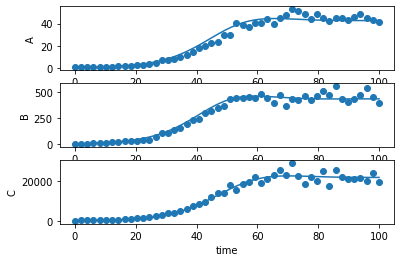

In [35]:
fig, ax = plt.subplots(3)
cmplist = ['A', 'B', 'C']
for (i, c) in enumerate(cmplist):
    ax[i].scatter(D_frame.index, D_frame[c])
    ax[i].plot(results_pyomo.Z.index, results_pyomo.Z[c])
    ax[i].set_xlabel('time')
    ax[i].set_ylabel(c)

In the book, they look at the covariance matrix of parameters (which are log10(k)). To look at a covariance matrix for ln(k) we need to do the following transformation of the estimated covariance matrix
$$ Cov(ln(k)) = Diag(k)^{-1}Cov(k)Diag(k)^{-1} $$

In [23]:
# scaled covariance
k_diag_inv = np.diag(1 / np.array(list(results_pyomo.P.values())))
cov_est_scaled = np.dot(np.dot(k_diag_inv, cov_est), k_diag_inv)
cov_est_scaled

array([[ 0.00505042, -0.03164672, -0.00329805, -0.0301906 , -0.00463478,
         0.00772458],
       [-0.03164672,  0.3211751 ,  0.04137482,  0.33498589,  0.04252301,
        -0.08766621],
       [-0.00329805,  0.04137482,  0.0351555 ,  0.04531078,  0.03468948,
        -0.01400838],
       [-0.0301906 ,  0.33498589,  0.04531078,  0.35388047,  0.04423099,
        -0.09329183],
       [-0.00463478,  0.04252301,  0.03468948,  0.04423099,  0.03653187,
        -0.01311016],
       [ 0.00772458, -0.08766621, -0.01400838, -0.09329183, -0.01311016,
         0.02520614]])

In [25]:
eigval, eigvec = sla.eig(cov_est_scaled)

In [27]:
eigval, max(eigval) / min(eigval)

(array([7.12465634e-01+0.j, 5.83282477e-02+0.j, 5.15796266e-03+0.j,
        7.91899100e-04+0.j, 1.22501660e-05+0.j, 2.43502145e-04+0.j]),
 (58159.67172603623+0j))

In [29]:
eigvec[:, 4], eigvec[:, 5]

(array([-0.59699895, -0.51880256, -0.02863722,  0.52246646,  0.03589106,
         0.31520897]),
 array([ 0.09699673,  0.2301467 ,  0.49426341, -0.03153523, -0.43511979,
         0.70922783]))